In [1]:
from dynamic_pricing.db.db_utils import get_db_connection, load_order_data
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
conn = get_db_connection()

df: pd.DataFrame = load_order_data(conn,"nostimo")
print(df.info)

2024-03-18 02:11:14,023 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-03-18 02:11:14,024 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-18 02:11:14,219 INFO sqlalchemy.engine.Engine select current_schema()
2024-03-18 02:11:14,221 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-18 02:11:14,414 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-03-18 02:11:14,416 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-03-18 02:11:15,292 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-03-18 02:11:15,294 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [3]:
print(df.columns)
df.head()
df.fillna(0, inplace=True)

Index(['order_id', 'deliveroo_order_id', 'deliveroo_order_number',
       'order_status', 'order_placed_timestamp', 'order_updated_timestamp',
       'order_prepare_for_timestamp', 'order_start_prepping_at_timestamp',
       'customer_id', 'first_name', 'contact_number', 'contact_access_code',
       'partner_id', 'partner_name', 'item_id', 'deliveroo_item_id',
       'item_name', 'item_operational_name', 'item_quantity',
       'item_fractional_price', 'modifier_id', 'deliveroo_modifier_id',
       'modifier_name', 'modifier_operational_name', 'modifier_quantity',
       'modifier_fractional_price'],
      dtype='object')


/tmp/ipykernel_99105/787573481.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(0, inplace=True)


Filter to keep only the items we are analyzing

In [4]:
pre_dp_df = df[~df["item_operational_name"].str.contains("Wrap")]
pre_dp_df = pre_dp_df[
    (pre_dp_df["order_placed_timestamp"] >= "2023-06-26")
    & (pre_dp_df["order_placed_timestamp"] < "2023-7-17")
]
pre_dp_df.info()


post_dp_df = df[~df["item_operational_name"].str.contains("Wrap")]
post_dp_df = post_dp_df[
    (post_dp_df["order_placed_timestamp"] >= "2023-7-17")
    & (post_dp_df["order_placed_timestamp"] < "2023-8-07")
]
post_dp_df.info()

interval = 30

<class 'pandas.core.frame.DataFrame'>
Index: 176 entries, 3 to 239
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           176 non-null    int64         
 1   deliveroo_order_id                 176 non-null    object        
 2   deliveroo_order_number             176 non-null    int64         
 3   order_status                       176 non-null    object        
 4   order_placed_timestamp             176 non-null    datetime64[ns]
 5   order_updated_timestamp            176 non-null    datetime64[ns]
 6   order_prepare_for_timestamp        176 non-null    datetime64[ns]
 7   order_start_prepping_at_timestamp  176 non-null    datetime64[ns]
 8   customer_id                        176 non-null    int64         
 9   first_name                         176 non-null    int64         
 10  contact_number                     176 non-

In [6]:
def split_weekdays_and_weekends(df:pd.DataFrame,time_col:str):
    weekdays_df = df[
        df[time_col].dt.dayofweek < 5
    ]
    weekend_df = df[df[time_col].dt.dayofweek >= 5]
    return weekdays_df, weekend_df


pre_dp_df_weekdays, pre_dp_df_weekends = split_weekdays_and_weekends(
    pre_dp_df, "order_placed_timestamp"
)
post_dp_df_weekdays, post_dp_df_weekends = split_weekdays_and_weekends(
    post_dp_df, "order_placed_timestamp"
)

analysis

/tmp/ipykernel_99105/3244536412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (


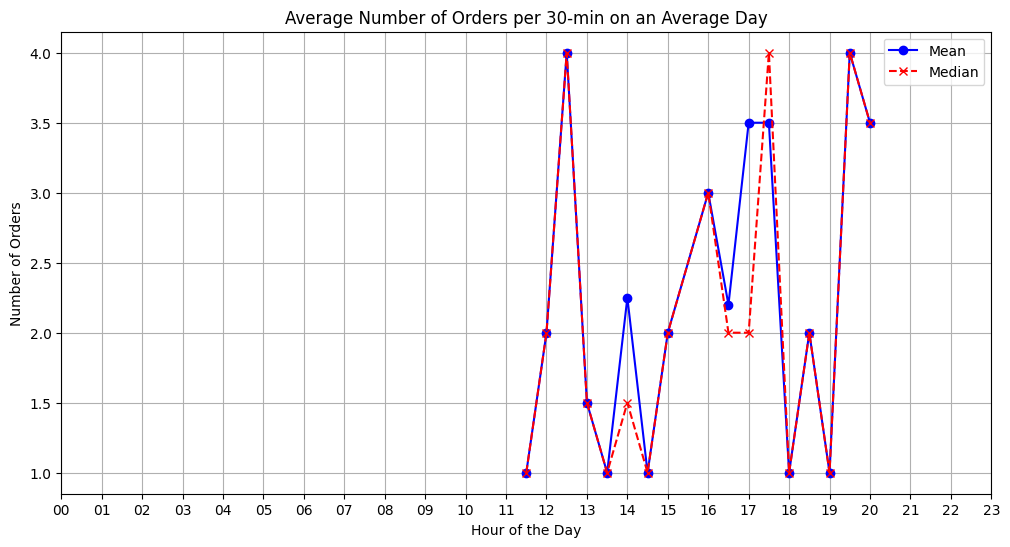

/tmp/ipykernel_99105/3244536412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (


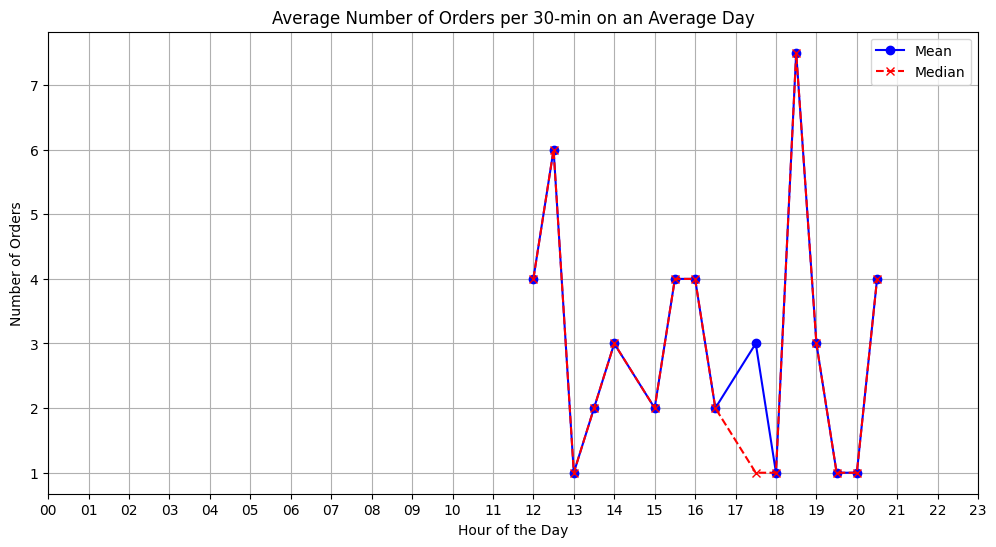

/tmp/ipykernel_99105/3244536412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (


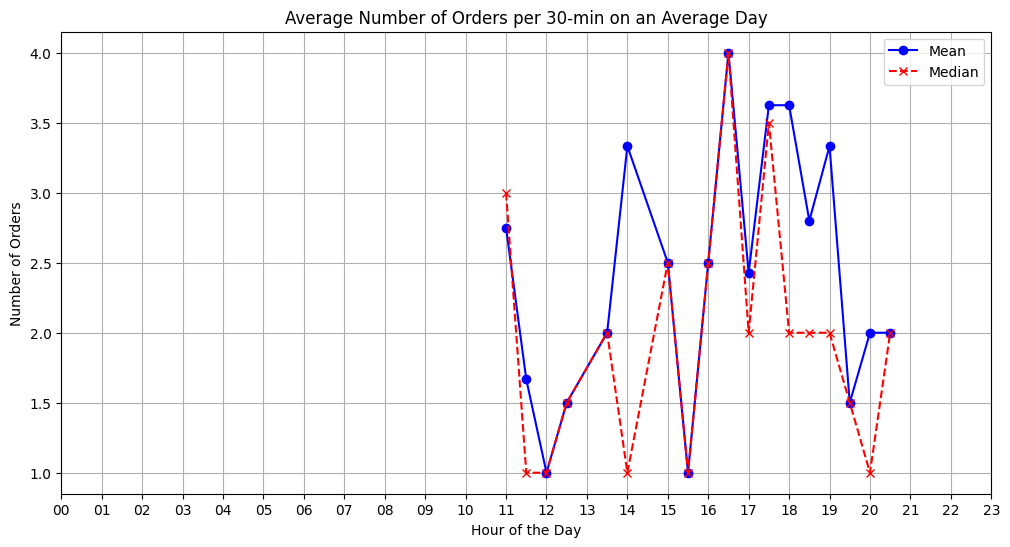

/tmp/ipykernel_99105/3244536412.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (


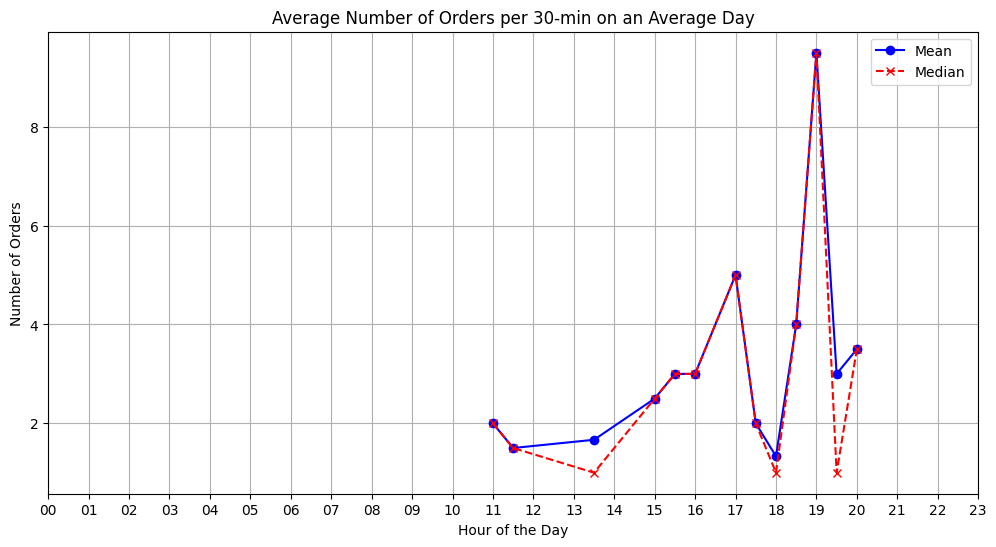

In [7]:
def plot_average_orders_per_interval(df: pd.DataFrame, interval: int):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60
        + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the actual average number of orders for each interval on an average day
    actual_average_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .mean()
    )

    # Calculate the median number of orders for each interval on an average day
    median_orders = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])
        .size()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median
    plt.figure(figsize=(12, 6))
    plt.plot(
        actual_average_orders, marker="o", linestyle="-", color="blue", markersize=6, label="Mean"
    )
    plt.plot(
        median_orders, marker="x", linestyle="--", color="red", markersize=6, label="Median"
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Number of Orders")
    plt.title(f"Average Number of Orders per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_orders_per_interval(pre_dp_df_weekdays, interval=interval)
plot_average_orders_per_interval(pre_dp_df_weekends, interval=interval)

plot_average_orders_per_interval(post_dp_df_weekdays, interval=interval)
plot_average_orders_per_interval(post_dp_df_weekends, interval=interval)

   order_id  item_quantity  item_fractional_price  modifier_fractional_price  \
3         4              1                    280                          0   
4         4              1                   1050                          0   
5         4              1                    160                          0   
6         4              1                   1650                          0   
9         8              1                    750                          0   

   modifier_quantity order_placed_timestamp  order_value  revenue  
3                  0    2023-06-26 17:42:24          2.8     31.4  
4                  0    2023-06-26 17:42:24         10.5     31.4  
5                  0    2023-06-26 17:42:24          1.6     31.4  
6                  0    2023-06-26 17:42:24         16.5     31.4  
9                  0    2023-06-26 18:23:14          7.5      7.5  


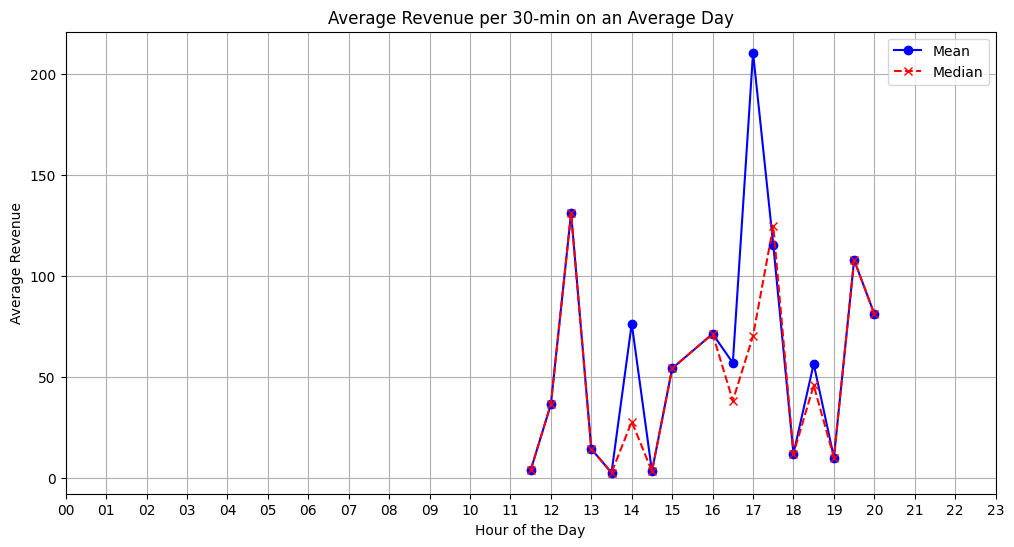

    order_id  item_quantity  item_fractional_price  modifier_fractional_price  \
47        42              1                    850                          0   
48        42              1                   1650                          0   
49        44              1                   1700                          0   
50        44              1                    160                          0   
52        46              1                    260                          0   

    modifier_quantity order_placed_timestamp  order_value  revenue  
47                  0    2023-07-01 12:03:05          8.5     25.0  
48                  0    2023-07-01 12:03:05         16.5     25.0  
49                  0    2023-07-01 12:06:25         17.0     18.6  
50                  0    2023-07-01 12:06:25          1.6     18.6  
52                  0    2023-07-01 12:49:02          2.6      2.6  


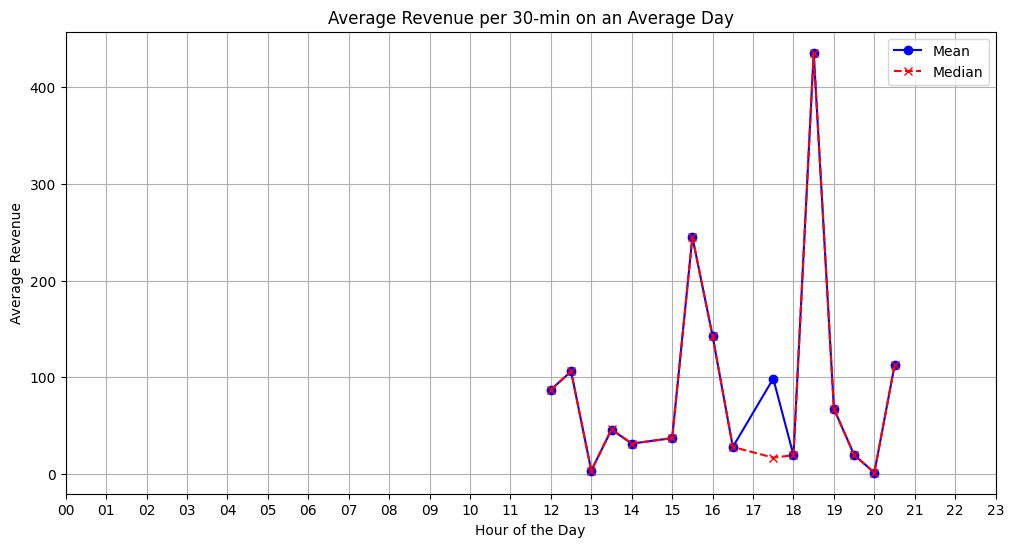

     order_id  item_quantity  item_fractional_price  \
242       214              1                    750   
243       214              1                    630   
245       216              1                   1050   
246       216              1                    350   
247       216              1                    800   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
242                          0                  0    2023-07-17 16:06:41   
243                          0                  0    2023-07-17 16:06:41   
245                          0                  0    2023-07-17 16:37:34   
246                          0                  0    2023-07-17 16:37:34   
247                          0                  0    2023-07-17 16:37:34   

     order_value  revenue  
242          7.5     13.8  
243          6.3     13.8  
245         10.5     32.5  
246          3.5     32.5  
247          8.0     32.5  


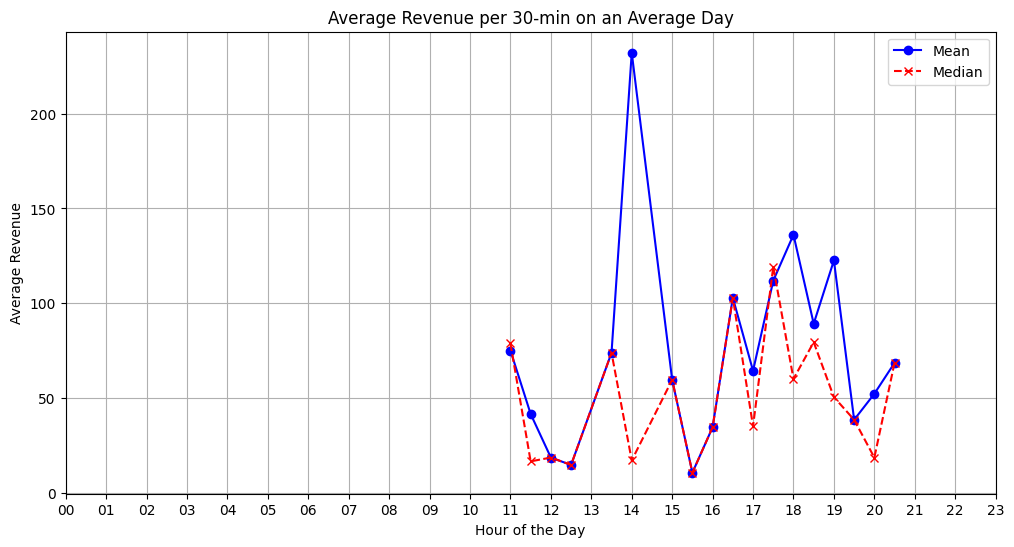

     order_id  item_quantity  item_fractional_price  \
285       256              1                   1920   
286       256              1                    280   
288       258              1                    350   
289       260              1                   1700   
290       260              1                    280   

     modifier_fractional_price  modifier_quantity order_placed_timestamp  \
285                          0                  0    2023-07-22 11:14:33   
286                          0                  0    2023-07-22 11:14:33   
288                          0                  0    2023-07-22 13:33:43   
289                          0                  0    2023-07-22 13:34:42   
290                          0                  0    2023-07-22 13:34:42   

     order_value  revenue  
285         19.2     22.0  
286          2.8     22.0  
288          3.5      3.5  
289         17.0     19.8  
290          2.8     19.8  


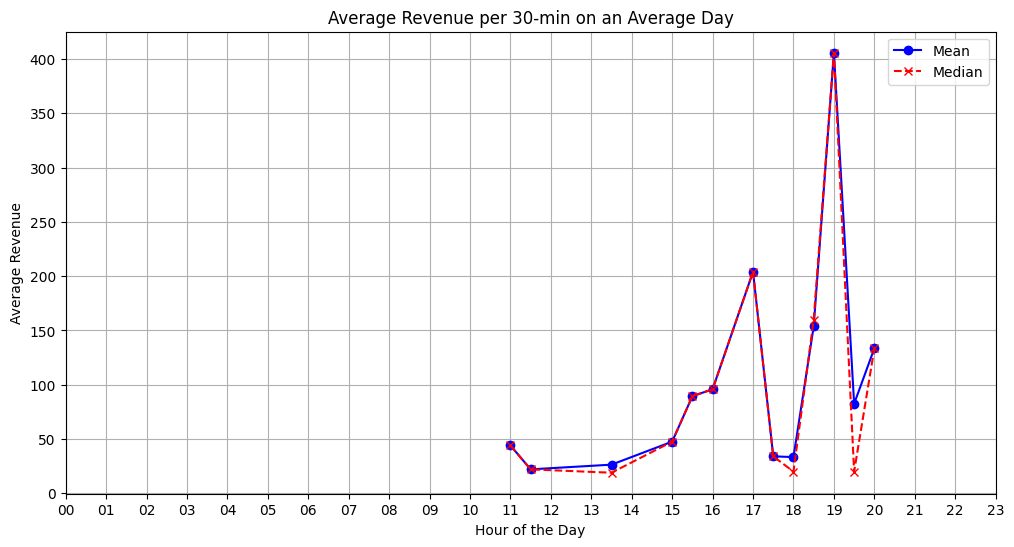

In [8]:
def calculate_revenue(df: pd.DataFrame,order_timestamp_column:str):
    # Calculate the actual average revenue for each interval on an average day
    df = df[
        [
            "order_id",
            "item_quantity",
            "item_fractional_price",
            "modifier_fractional_price",
            "modifier_quantity",
            order_timestamp_column,
        ]
    ].copy()
    df.fillna(0, inplace=True)
    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    # print(df.groupby("order_id").head())
    df["revenue"] = df.groupby("order_id")["order_value"].transform("sum")
    return df


def plot_average_revenue_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    df = calculate_revenue(df,order_timestamp)
    # print(df["revenue"])
    print(df.head())
    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the mean and median revenue for each interval
    mean_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .mean()
    )

    median_revenue = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plot both mean and median revenue per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_revenue,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_revenue,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Average Revenue")
    plt.title(f"Average Revenue per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, int(60 / interval)), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_revenue_per_interval(pre_dp_df_weekdays, interval)
plot_average_revenue_per_interval(pre_dp_df_weekends, interval)

plot_average_revenue_per_interval(post_dp_df_weekdays, interval)
plot_average_revenue_per_interval(post_dp_df_weekends, interval)

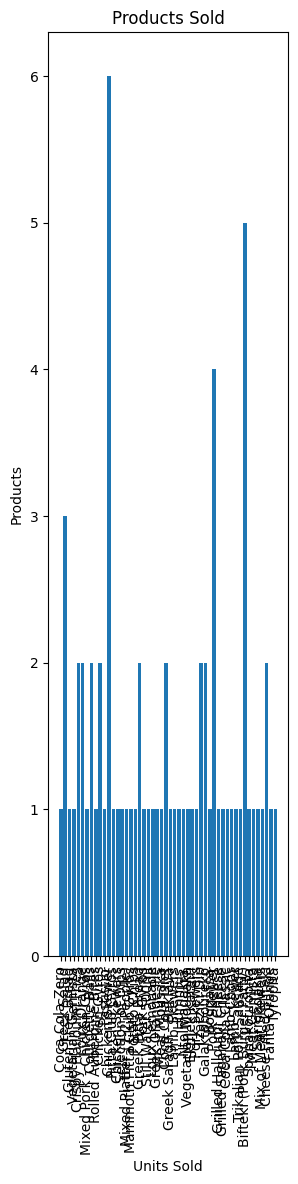

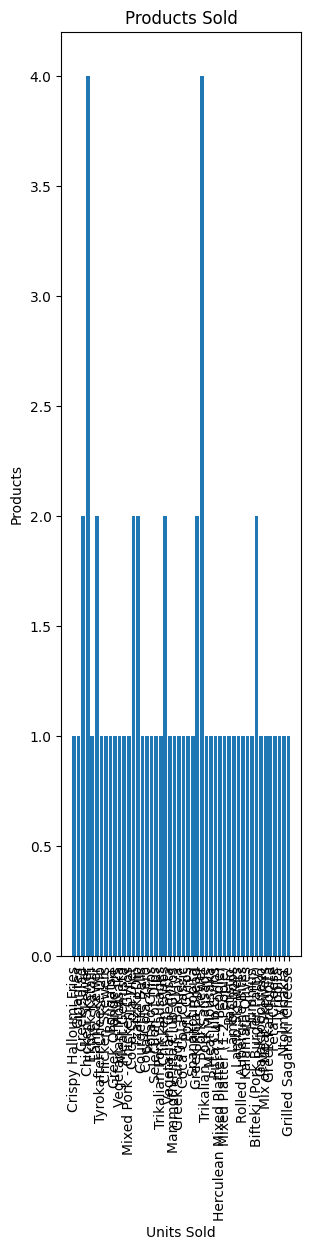

In [9]:
def plot_items_sold(df):
    df = df[["order_id","item_name","item_quantity"]].copy()

    plt.figure(figsize=(6, 12))
    plt.bar(df["item_name"], df["item_quantity"])
    plt.ylabel('Products')
    plt.xlabel('Units Sold')
    plt.title('Products Sold')
    plt.xticks(rotation=90)
    plt.subplots_adjust(left=0.5)  # Adjust the value as needed
    plt.show()

plot_items_sold(pre_dp_df)
plot_items_sold(post_dp_df)

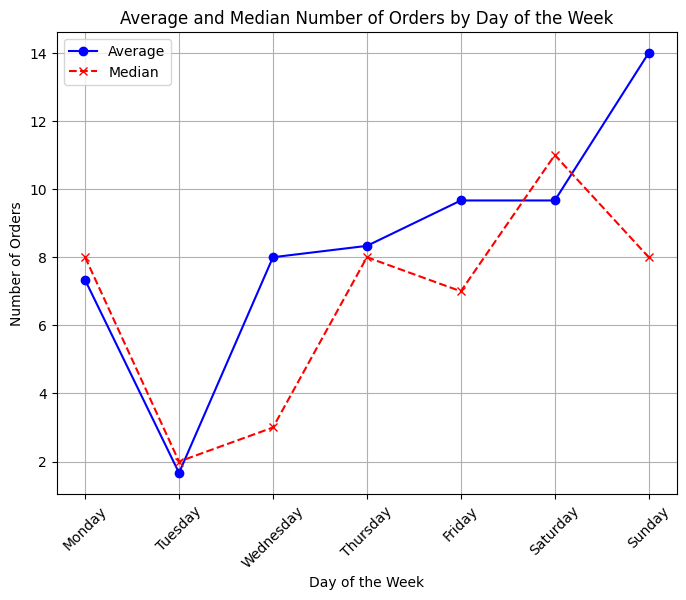

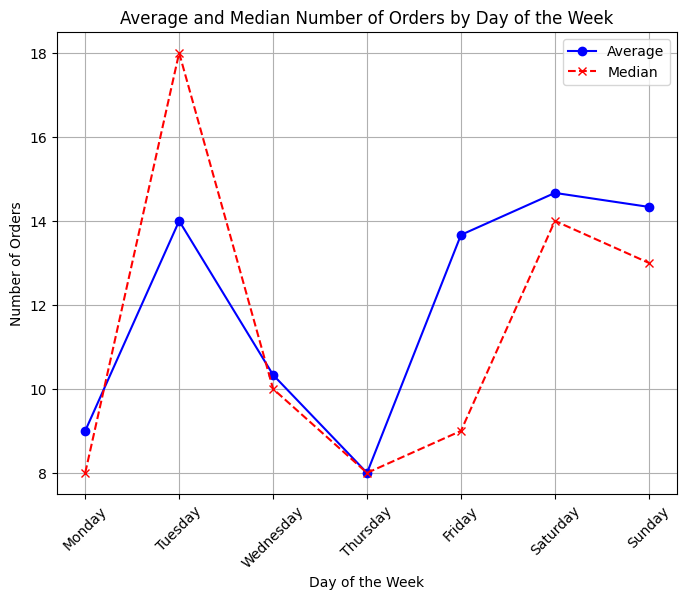

In [10]:
def plot_average_orders_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    # Group by day of the week and calculate both average and median number of orders
    average_orders = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])
        .size()
        .groupby("day_of_week")
        .mean()
    )
    median_orders = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])
        .size()
        .groupby("day_of_week")
        .median()
    )

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Reindex the DataFrames to include all weekdays in the desired order
    average_orders = average_orders.reindex(weekdays)
    median_orders = median_orders.reindex(weekdays)

    # Generate the x-axis labels for the day of the week
    x_labels = weekdays

    # Plotting both average and median number of orders by day of the week as a line plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        average_orders,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Average",
    )
    plt.plot(
        median_orders,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Number of Orders")
    plt.title("Average and Median Number of Orders by Day of the Week")
    plt.xticks(range(len(weekdays)), x_labels, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_orders_by_day_of_week(pre_dp_df)
plot_average_orders_by_day_of_week(post_dp_df)

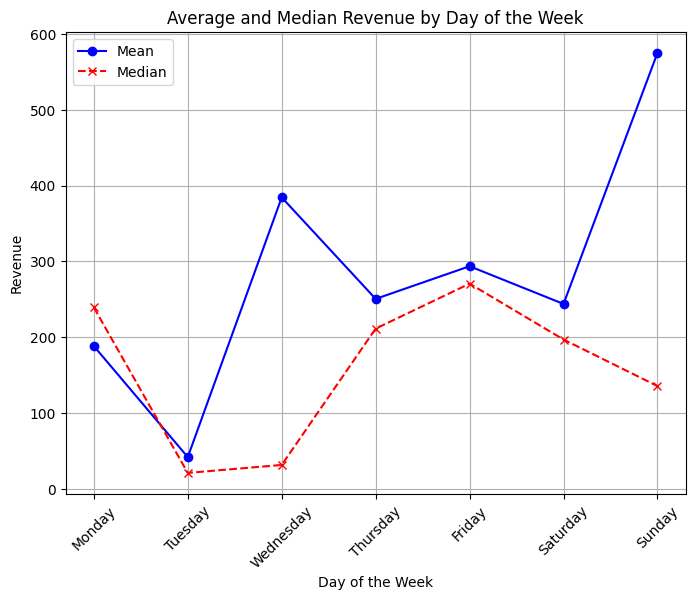

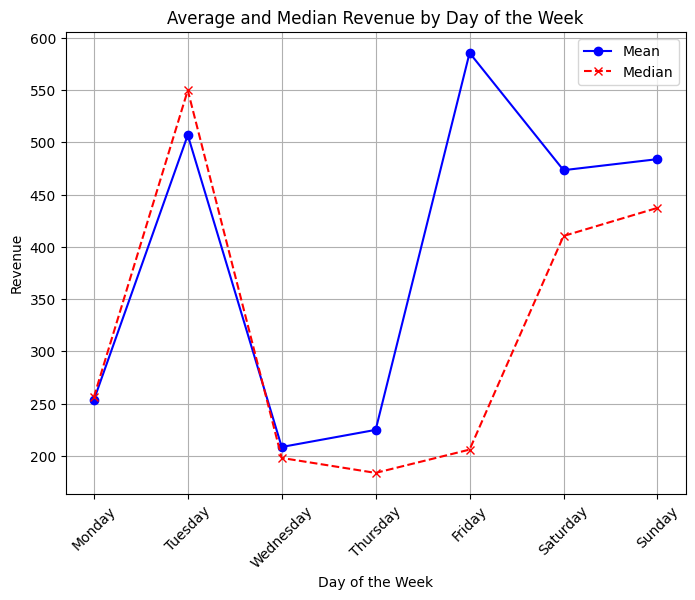

In [11]:
def plot_average_revenue_by_day_of_week(df):
    order_timestamp = "order_placed_timestamp"
    # Calculate the average revenue by day of the week
    df = calculate_revenue(df,order_timestamp)

    # Extract the day of the week from the order_datetime column
    df["day_of_week"] = df[order_timestamp].dt.day_name()

    average_revenue_by_day = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("day_of_week")
        .mean()
    )
    median_revenue_by_day = (
        df.groupby(["day_of_week", df[order_timestamp].dt.date])["revenue"]
        .sum()
        .groupby("day_of_week")
        .median()
    )

    # Define the order of days for proper sorting in the plot
    weekdays = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Reindex the DataFrames to include all weekdays in the desired order
    average_revenue_by_day = average_revenue_by_day.reindex(weekdays)
    median_revenue_by_day = median_revenue_by_day.reindex(weekdays)

    # Generate the x-axis labels for the day of the week
    x_labels = weekdays

    # Plotting both mean and median revenue by day of the week as a line plot
    plt.figure(figsize=(8, 6))
    plt.plot(
        average_revenue_by_day,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_revenue_by_day,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Day of the Week")
    plt.ylabel("Revenue")
    plt.title("Average and Median Revenue by Day of the Week")
    plt.xticks(range(len(weekdays)), x_labels, rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_average_revenue_by_day_of_week(pre_dp_df)
plot_average_revenue_by_day_of_week(post_dp_df)

/tmp/ipykernel_99105/2273651215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/2273651215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


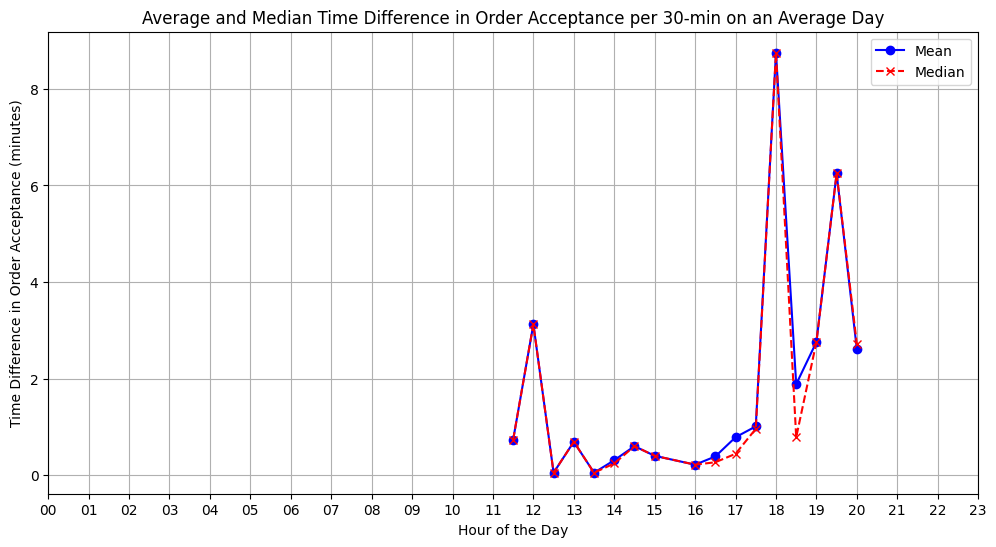

/tmp/ipykernel_99105/2273651215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/2273651215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


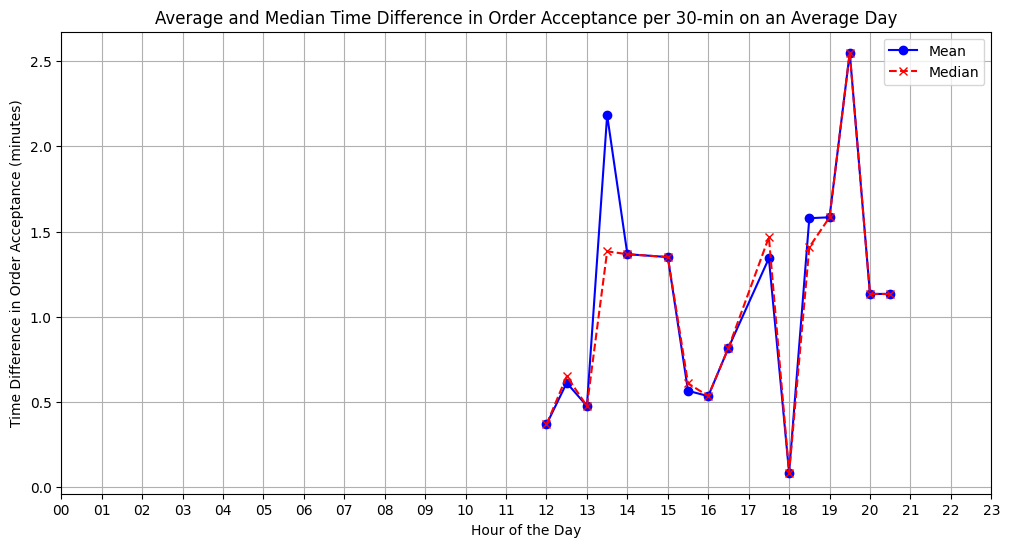

/tmp/ipykernel_99105/2273651215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/2273651215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


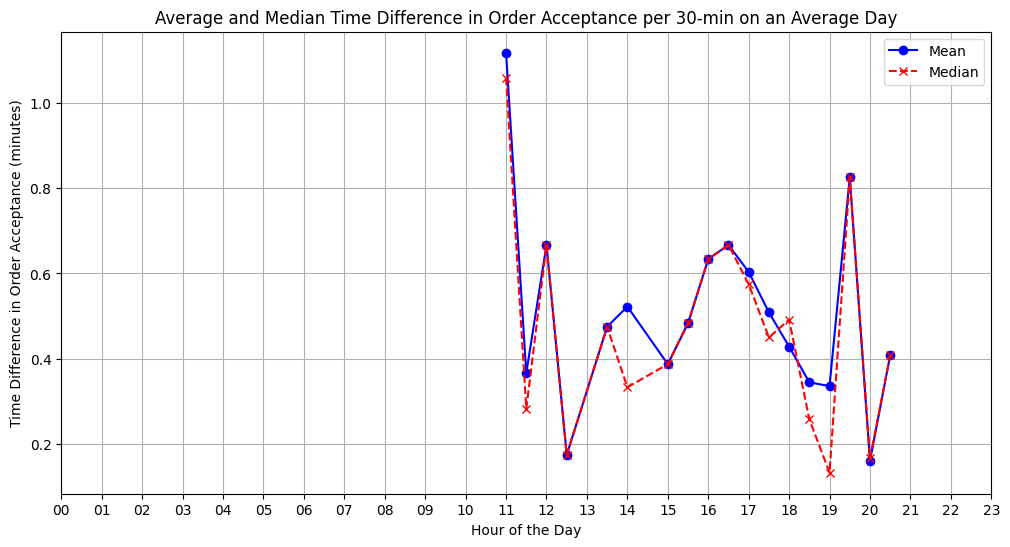

/tmp/ipykernel_99105/2273651215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/2273651215.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


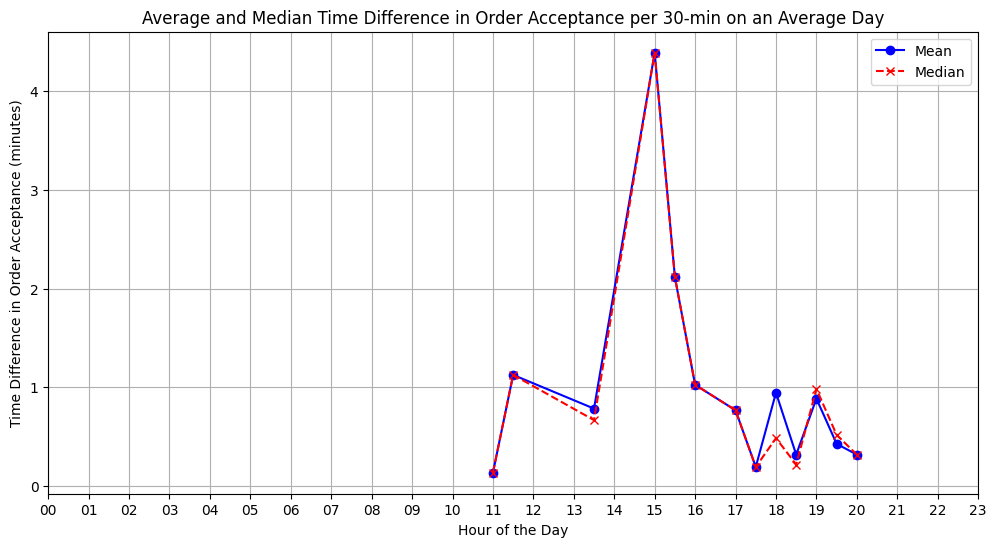

In [12]:
def time_difference_in_order_acceptance_per_interval(df, interval):
    order_timestamp = "order_placed_timestamp"
    accepted_timestamp = "order_updated_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[order_timestamp].dt.hour * 60 + df[order_timestamp].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[accepted_timestamp] - df[order_timestamp]
    ).dt.total_seconds() / 60

    # Calculate both mean and median time difference for each interval on an average day
    mean_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    median_time_difference = (
        df.groupby(["interval_index", df[order_timestamp].dt.date])["time_difference"]
        .median()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median time difference in order acceptance per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_time_difference,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_time_difference,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Time Difference in Order Acceptance (minutes)")
    plt.title(
        f"Average and Median Time Difference in Order Acceptance per {interval}-min on an Average Day"
    )
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

time_difference_in_order_acceptance_per_interval(pre_dp_df_weekdays, interval)
time_difference_in_order_acceptance_per_interval(pre_dp_df_weekends, interval)

time_difference_in_order_acceptance_per_interval(post_dp_df_weekdays, interval)
time_difference_in_order_acceptance_per_interval(post_dp_df_weekends, interval)

/tmp/ipykernel_99105/193725362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/193725362.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


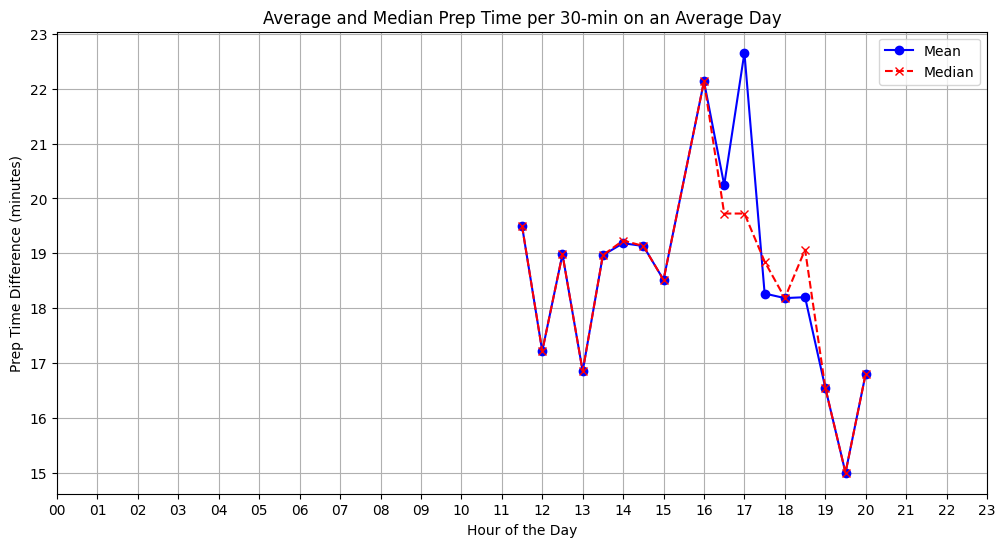

/tmp/ipykernel_99105/193725362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/193725362.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


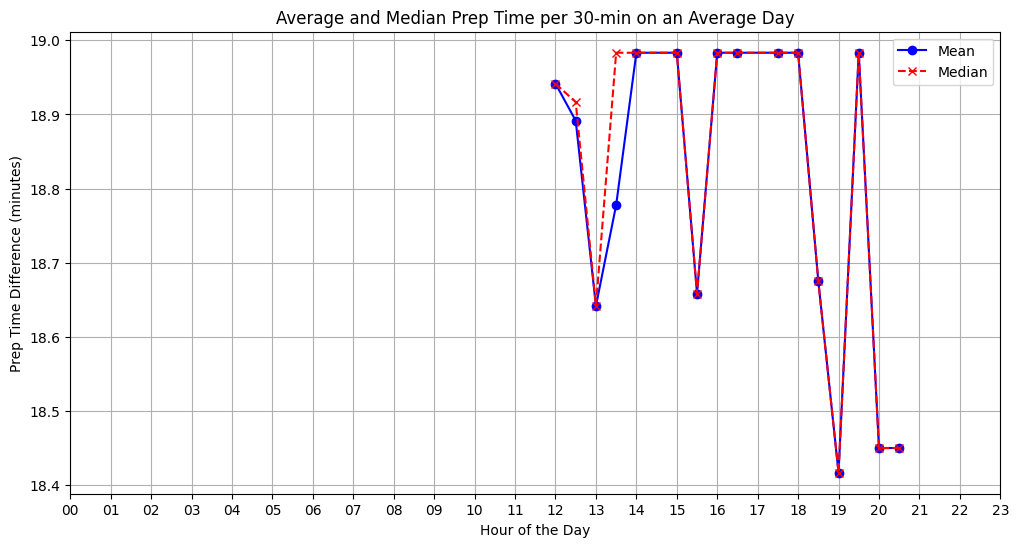

/tmp/ipykernel_99105/193725362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/193725362.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


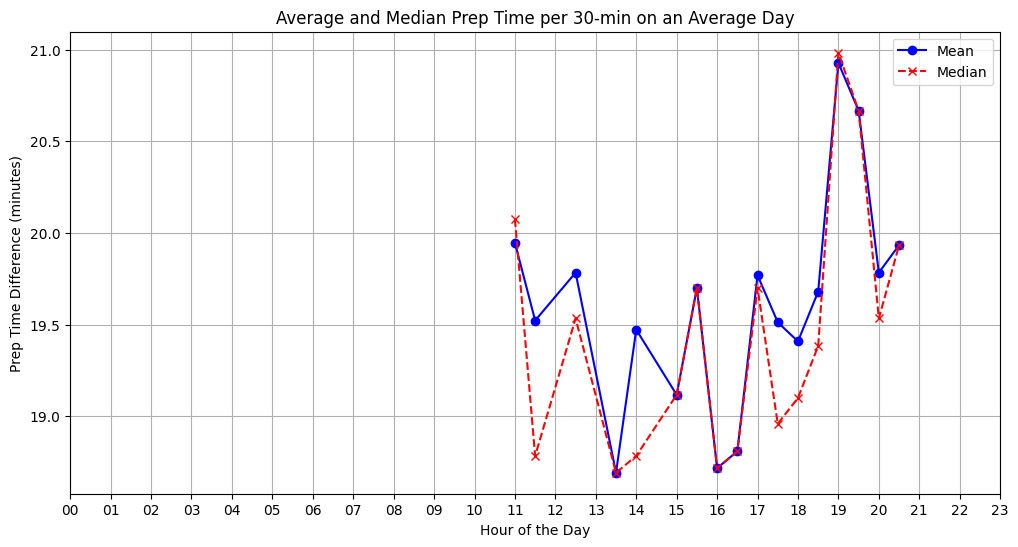

/tmp/ipykernel_99105/193725362.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_index"] = (
/tmp/ipykernel_99105/193725362.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time_difference"] = (


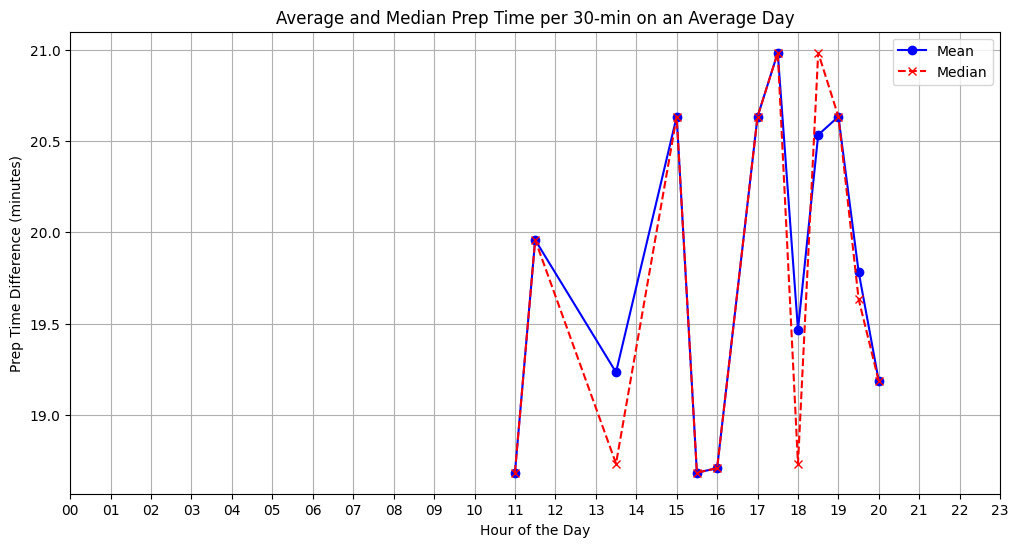

In [13]:
def prep_time_per_interval(df, interval):
    """Use https://api-docs.deliveroo.com/v2.0/docs/order-integration to understand why these timestamps are used"""
    start_prep_time = "order_start_prepping_at_timestamp"
    end_prep_time = "order_prepare_for_timestamp"
    # Calculate the total number of intervals in a day based on the given interval
    num_intervals = (24 * 60) // interval

    # Create a new column for the interval index
    df["interval_index"] = (
        df[start_prep_time].dt.hour * 60 + df[start_prep_time].dt.minute
    ) // interval

    # Calculate the time difference between order placement and acceptance
    df["time_difference"] = (
        df[end_prep_time] - df[start_prep_time]
    ).dt.total_seconds() / 60

    # Calculate both mean and median time difference for each interval on an average day
    mean_time_difference = (
        df.groupby(["interval_index", df[start_prep_time].dt.date])["time_difference"]
        .mean()
        .groupby("interval_index")
        .mean()
    )

    median_time_difference = (
        df.groupby(["interval_index", df[start_prep_time].dt.date])["time_difference"]
        .median()
        .groupby("interval_index")
        .median()
    )

    # Generate the x-axis labels for the hour of the day
    x_labels = [f"{hour:02d}" for hour in range(24)]

    # Plotting both mean and median prep time per interval
    plt.figure(figsize=(12, 6))
    plt.plot(
        mean_time_difference,
        marker="o",
        linestyle="-",
        color="blue",
        markersize=6,
        label="Mean",
    )
    plt.plot(
        median_time_difference,
        marker="x",
        linestyle="--",
        color="red",
        markersize=6,
        label="Median",
    )
    plt.xlabel("Hour of the Day")
    plt.ylabel("Prep Time Difference (minutes)")
    plt.title(f"Average and Median Prep Time per {interval}-min on an Average Day")
    plt.xticks(range(0, num_intervals, 60 // interval), x_labels)
    plt.grid(True)
    plt.legend()
    plt.show()

prep_time_per_interval(pre_dp_df_weekdays, interval)
prep_time_per_interval(pre_dp_df_weekends, interval)

prep_time_per_interval(post_dp_df_weekdays, interval)
prep_time_per_interval(post_dp_df_weekends, interval)

Manage outliers

In [14]:
revenue_df = calculate_revenue(pre_dp_df,"order_placed_timestamp")
largest_series = revenue_df["revenue"].nlargest(5).reset_index(drop=True)
print(largest_series)
difference_amount = largest_series[1]-largest_series[2]
print(difference_amount)
revenue_df[revenue_df["revenue"] == largest_series[1]] #the outlier was on a wednesday at 5.26pm

0    113.0
1    113.0
2    113.0
3    113.0
4    113.0
Name: revenue, dtype: float64
0.0


,order_id,item_quantity,item_fractional_price,modifier_fractional_price,modifier_quantity,order_placed_timestamp,order_value,revenue
117,98,3,1050,0,0,2023-07-05 17:26:42,31.5,113.0
119,98,2,750,0,0,2023-07-05 17:26:42,15.0,113.0
120,98,2,850,0,0,2023-07-05 17:26:42,17.0,113.0
121,98,1,350,0,0,2023-07-05 17:26:42,3.5,113.0
122,98,1,1000,0,0,2023-07-05 17:26:42,10.0,113.0
123,98,2,600,0,0,2023-07-05 17:26:42,12.0,113.0
124,98,1,1950,0,0,2023-07-05 17:26:42,19.5,113.0
125,98,1,450,0,0,2023-07-05 17:26:42,4.5,113.0


In [15]:
import pandas as pd


def calculate_revenue_by_day_period(
    df, order_timestamp_column="order_placed_timestamp", time_intervals=None
):

    if time_intervals is None:
        raise ValueError("Please provide time intervals.")

    df["order_value"] = (
        (df["item_fractional_price"] * df["item_quantity"])
        + (df["modifier_fractional_price"] * df["modifier_quantity"])
    ) / 100
    time_intervals = [pd.to_datetime(str(time)).time() for time in time_intervals]

    interval_labels = [
        f"{time_intervals[i]} to {time_intervals[i+1]}"
        for i in range(len(time_intervals) - 1)
    ]

    df["interval_label"] = pd.cut(
        df[order_timestamp_column].dt.time, bins=time_intervals, labels=interval_labels
    )

    return df.groupby("interval_label", observed=True)["order_value"].sum()

time_intervals = ["00:00", "14:00", "18:45", "23:59:59"]
pre_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekdays, time_intervals=time_intervals
)

pre_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    pre_dp_df_weekends, time_intervals=time_intervals
)
post_dp_df_weekday_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekdays, time_intervals=time_intervals
)
post_dp_df_weekend_revenue = calculate_revenue_by_day_period(
    post_dp_df_weekends, time_intervals=time_intervals
)

print(pre_dp_df_weekday_revenue, pre_dp_df_weekday_revenue.sum())
print(pre_dp_df_weekend_revenue, pre_dp_df_weekend_revenue.sum())
print(post_dp_df_weekday_revenue, post_dp_df_weekday_revenue.sum())
print(post_dp_df_weekend_revenue, post_dp_df_weekend_revenue.sum())

interval_label
00:00:00 to 14:00:00     88.7
14:00:00 to 18:45:00    878.8
18:45:00 to 23:59:59    148.9
Name: order_value, dtype: float64 1116.4
interval_label
00:00:00 to 14:00:00    178.5
14:00:00 to 18:45:00    381.0
18:45:00 to 23:59:59    144.5
Name: order_value, dtype: float64 704.0
interval_label
00:00:00 to 14:00:00     279.2
14:00:00 to 18:45:00    1310.0
18:45:00 to 23:59:59     345.4
Name: order_value, dtype: float64 1934.6
interval_label
00:00:00 to 14:00:00    113.7
14:00:00 to 18:45:00    288.7
18:45:00 to 23:59:59    480.1
Name: order_value, dtype: float64 882.5


/tmp/ipykernel_99105/3156838893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_value"] = (
/tmp/ipykernel_99105/3156838893.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["interval_label"] = pd.cut(
/tmp/ipykernel_99105/3156838893.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

checkout any major events 
look at seasionality of the month